# imports

In [1]:
%matplotlib notebook

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import theano
from theano import config
import theano.tensor as T
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import time
from scipy.optimize import minimize
from climin.util import optimizer

gnumpy: failed to import cudamat. Using npmat instead. No GPU will be used.


In [3]:
from schlichtanders.myfunctools import compose, summap, meanmap
from IPython.display import IFrame

In [4]:
import theano_models as tm
import theano_models.probabilistic_models as pm
import theano_models.deterministic_models as dm

# Testing Gauss Distribution

For this test we simply try to approximate a diagonal gaussian distribution to given gaussian samples.

## model

In [5]:
size = 2
model = pm.DiagGauss(size)
model

DiagGauss { 'inputs': [],
  'outputs': DiagGauss.outputs,
  'parameters': [mean],
  'parameters_positive': [var]}

In [6]:
parameters = tm.prox_reparameterize(model['parameters_positive'], tm.softplus, tm.softplus_inv)
parameters += model['parameters']
flat = tm.prox_flatten(tm.prox_center(parameters))

## target

In [7]:
target = pm.DiagGauss(init_mean=[4,10], init_var=[0.5,2])

In [8]:
sampler = target.function()
sampler()

array([ 4.64749682,  8.7113353 ])

In [9]:
n_samples = 400
targets = np.array([sampler() for _ in xrange(n_samples)])

## visualization

In [10]:
model_meanvar = theano.function([flat], [model.mean, model.var])
target_mean, target_var = target.mean.eval(), target.var.eval()

def plot_fit(ax, wrt, time_delay=0.1):
    """ interactive plot of model fit
    
    Plots target data set as well as two Ellipse around target and model mean with width/height = 2* respective
    standard deviation.
    """
    ax.clear()
    ax.set_xlabel("x0")
    ax.set_ylabel("x1")
    
    # plot data
    # ---------
    ax.plot(targets[:,0], targets[:,1], 'k.')
    
    # plot target
    # -----------
    # Ellipse
    e = Ellipse(target_mean, width=2*np.sqrt(target_var[0]), height=2*np.sqrt(target_var[1]))
    e.set_clip_box(ax.bbox)
    e.set_alpha(0.1)
    e.set_facecolor([1, 0.1, 0.1])
    ax.add_patch(e)

    # plot model
    # -----------
    model_mean, model_var = model_meanvar(wrt)
    # text
    ax.text(0.1, 0.2, 'm=%g,%g' % tuple(model_mean),
            verticalalignment='bottom', horizontalalignment='left',
            transform=ax.transAxes)
    ax.text(0.1, 0.1, 'v=%g,%g' % tuple(model_var),
            verticalalignment='bottom', horizontalalignment='left',
            transform=ax.transAxes)
    # Ellipse
    e = Ellipse(model_mean, width=2*np.sqrt(model_var[0]), height=2*np.sqrt(model_var[1]))
    e.set_clip_box(ax.bbox)
    e.set_alpha(0.2)
    e.set_facecolor([0.1, 0.2, 0.4])
    ax.add_patch(e)
    # Point  # we need to add a normal plot, as then the axis adjust automatically
    ax.plot(model_mean[0], model_mean[1], '+', color=[0.1, 0.2, 0.4], markersize=10)
    
    # interactively redraw
    # --------------------
    ax.figure.canvas.draw()
    time.sleep(time_delay) # just because the fit is to fast otherwise

<IPython.core.display.Javascript object>


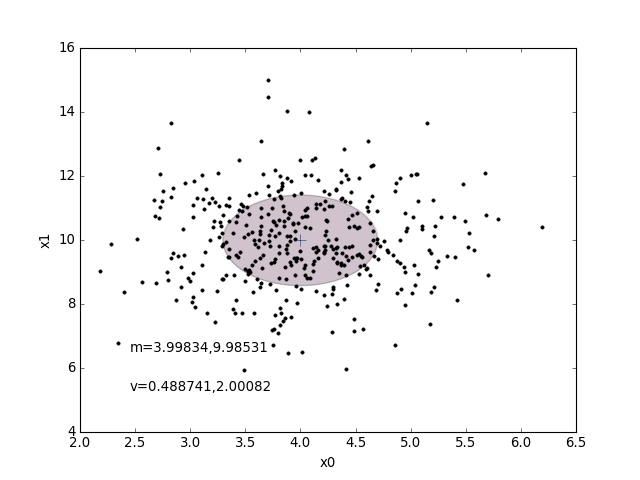

In [11]:
fig, ax = plt.subplots()
plot_fit(ax, flat.eval())

## fit

In [12]:
loss = tm.loss_probabilistic(model)
optimizer_kwargs = tm.numericalize(loss, flat, batch_mapreduce=meanmap)

In [13]:
fit = minimize(
    args=(targets,),
    method="Newton-CG",
    options={'maxiter':100, 'disp':True},
    callback=lambda xs: plot_fit(ax, xs),
    **tm.scipy_kwargs(optimizer_kwargs)
); fit

batch_precompile
batch_precompile
batch_precompile
Optimization terminated successfully.
         Current function value: 2.826694
         Iterations: 15
         Function evaluations: 18
         Gradient evaluations: 32
         Hessian evaluations: 15


     fun: 2.8266941032466075
     jac: array([ -5.50288339e-11,  -3.98182459e-08,  -1.32045486e-13,
         1.33787792e-08])
 message: 'Optimization terminated successfully.'
    nfev: 18
    nhev: 15
     nit: 15
    njev: 32
  status: 0
 success: True
       x: array([-1.00294397,  1.31420874,  3.99834417,  9.9853061 ])

Sometimes we might want to fix fitted model parameters into the model.

In [14]:
model_mean, model_var = model_meanvar(fit.x)
print model_mean, "~", target_mean
print model_var, "~", target_var

[ 3.99834417  9.9853061 ] ~ [  4.  10.]
[ 0.48874095  2.00081893] ~ [ 0.5  2. ]


# Uniform Distribution

## model

In [15]:
model = pm.Uniform(output_size=2)
model

Uniform { 'inputs': [],
  'outputs': Uniform.outputs,
  'parameters': [start],
  'parameters_positive': [offset]}

In [16]:
parameters = tm.prox_reparameterize(model['parameters_positive'], tm.softplus, tm.softplus_inv)
parameters += model['parameters']
flat = tm.prox_flatten(tm.prox_center(parameters))

## target

In [17]:
target = pm.Uniform(init_start=[1,4], init_offset=[2,1])
t_sampler = target.function()
t_sampler()

array([ 1.12327996,  4.26173365])

In [18]:
n_samples = 400
targets = np.array([t_sampler() for _ in xrange(n_samples)])

In [19]:
targets[:10]

array([[ 2.17383505,  4.98577291],
       [ 2.74702335,  4.26194121],
       [ 1.36586773,  4.53495397],
       [ 1.70428951,  4.10766679],
       [ 2.94154369,  4.15597178],
       [ 1.55378627,  4.82463795],
       [ 2.96962962,  4.45942601],
       [ 1.01653412,  4.14119672],
       [ 2.56283409,  4.68436447],
       [ 1.83129148,  4.35298923]])

## visualize

In [20]:
m_sampler = theano.function([flat], model['outputs'])
def plot_fit(ax, wrt, time_delay=0.1):
    ax.clear()
    # targets
    ax.plot(targets[:,0], targets[:,1], "k.")
    # model
    model_samples = np.array([m_sampler(wrt) for _ in xrange(n_samples)])
    ax.plot(model_samples[:,0], model_samples[:,1], "r.")
    ax.figure.canvas.draw()
    time.sleep(time_delay)

<IPython.core.display.Javascript object>


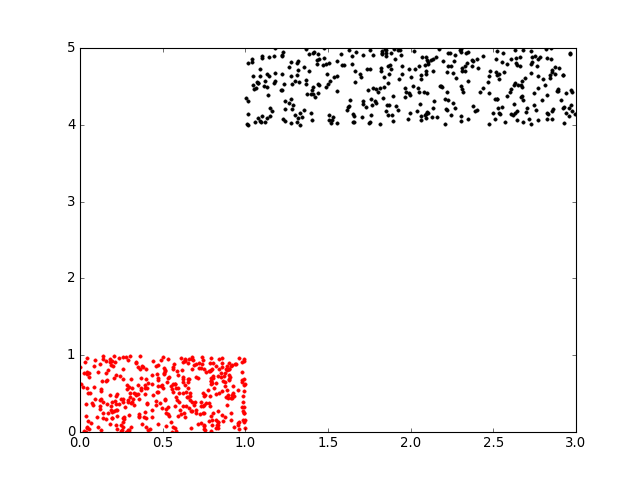

In [21]:
fig, ax = plt.subplots()
plot_fit(ax, flat.eval())

## fit

In [22]:
loss = tm.loss_probabilistic(model)
optimizer_kwargs = tm.numericalize(loss, flat, batch_mapreduce=meanmap)

In [23]:
fit = minimize(
    args=(targets,),
    method="Newton-CG",
    options={'maxiter':100, 'disp':True},
    callback=lambda xs: plot_fit(ax, xs),
    **tm.scipy_kwargs(optimizer_kwargs)
); fit

batch_precompile
batch_precompile
batch_precompile
         Current function value: inf
         Iterations: 0
         Function evaluations: 19
         Gradient evaluations: 7
         Hessian evaluations: 1


     fun: inf
     jac: array([ 0.63212056,  0.63212056,  0.        ,  0.        ])
 message: 'Desired error not necessarily achieved due to precision loss.'
    nfev: 19
    nhev: 1
     nit: 0
    njev: 7
  status: 2
 success: False
       x: array([ 0.,  0.,  0.,  0.])

TODO this does not work. Check whether the gradient is the reason (there is no gradient of the step probability function).